<a href="https://colab.research.google.com/github/jademene/Cloud-Cognitive-Services/blob/main/Titanic_Passenger_Survival_Prediction_using_Spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Titanic Passenger Survival Prediction using Spark**

## Task
Create a model that predicts which passengers survived the Titanic shipwreck <br>
Steps:
- Conduct Exploratory Data Analysis to gain insights into the dataset.
- Clean the data by addressing missing or incorrect values.
- Consider at classification algorithms and perform hyperparameter tuning for each algorithm.
- Compare the performance of the best models.
- Predict survivial of the passenger based on the best model.

## Colab Environement for Spark use


In [1]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Check this site for the latest download link https://www.apache.org/dyn/closer.lua/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark
!pip install py4j

import os
import sys
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"


import findspark
findspark.init()
findspark.find()

import pyspark

from pyspark.sql import DataFrame, SparkSession
from typing import List
import pyspark.sql.types as T
import pyspark.sql.functions as F

spark= SparkSession \
       .builder \
       .appName("Our First Spark Example") \
       .getOrCreate()

spark

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [830 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,756 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu

In [2]:
spark

## Import libraries

In [3]:
from pyspark.sql.functions import col, isnan, when, count, desc, udf, regexp_extract, expr, sum as spark_sum
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn
import pyspark

## Import data

Data from the 'train.csv' in the [Titanic - Machine Learning from Disaster](https://www.kaggle.com/c/titanic/overview) Kaggle competition.

In [ ]:
!git clone https://github.com/jademene/Cloud-Cognitive-Services.git

In [ ]:
df = spark.read.csv('Cloud-Cognitive-Services/train.csv', header = True)
df.cache() #makes its read faster

DataFrame[PassengerId: string, Survived: string, Pclass: string, Name: string, Sex: string, Age: string, SibSp: string, Parch: string, Ticket: string, Fare: string, Cabin: string, Embarked: string]

In [ ]:
df.show(20)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|  22|    1|    0|       A/5 21171|   7.25| NULL|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|  38|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|  26|    0|    0|STON/O2. 3101282|  7.925| NULL|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|  35|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|  35|    0|    0|          373450|   8.05| NULL|       S|
|          6|       0|     3|    Moran, Mr. James|  male|NULL|    0|    0|      

## 1) EDA

### 1.1) Data overview

In [ ]:
df.printSchema()

root
 |-- PassengerId: string (nullable = true)
 |-- Survived: string (nullable = true)
 |-- Pclass: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- SibSp: string (nullable = true)
 |-- Parch: string (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: string (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



For the sake of simplicity, numerical columns are converted from string to integer/double format.

In [5]:
df = df\
    .withColumn("PassengerId", col("PassengerId").cast(IntegerType()))\
    .withColumn("Survived", col("Survived").cast(IntegerType()))\
    .withColumn("Pclass", col("Pclass").cast(IntegerType()))\
    .withColumn("Age", col("Age").cast(IntegerType()))\
    .withColumn("SibSp", col("SibSp").cast(IntegerType()))\
    .withColumn("Parch", col("Parch").cast(IntegerType()))\
    .withColumn("Fare", col("Fare").cast(DoubleType()))

In [ ]:
df.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



**Variables Dictionary:**

- PassengerId: Identifier for each passenger.
- Survived: Survival status of the passenger.
  - 1 = Yes
  - 0 = No
- Pclass: Ticket class, serving as a proxy for socio-economic status.
  - 1 = 1st cabin
  - 2 = 2nd cabin
  - 3 = 3rd cabin
- Name: Full name of the passenger.
- Sex: Gender of the passenger.
- Age: Age of the passenger in years.
- SibSp: Number of siblings/spouses aboard.
- Parch: Number of parents/children aboard.
- Ticket: Ticket number.
- Fare: Fare paid by the passenger.
- Cabin: Cabin number.
- Embarked: Port of embarkation.
  - C = Cherbourg port
  - Q = Queenstown port
  - S = Southampton port

In [ ]:
print("rows:", df.count())
print("columns:", len(df.columns))

rows: 891
columns: 12


### 1.3) Duplicate values

In [ ]:
duplicates = df.count() - (df.dropDuplicates()).count()
print(f"Number of duplicate rows: {duplicates}")

# display the duplicate rows
if duplicates > 0:
    from pyspark.sql.functions import col
    # Columns to check for duplicates, if you want to specify: ['column1', 'column2']
    df.groupBy(df.columns).count().filter(col('count') > 1).drop('count').show()

Number of duplicate rows: 0


### 1.4) Missing values

In [ ]:
missing_data = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
missing_data.show()

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|177|    0|    0|     0|   0|  687|       2|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+



Missing values for:
- Age (177 missing values)
- Cabin (687 missing values)
- Embarked (2 missing values)

### 1.5) Statistical summary

In [ ]:
df.describe().show()

+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+
|summary|      PassengerId|           Survived|            Pclass|                Name|   Sex|               Age|             SibSp|              Parch|            Ticket|             Fare|Cabin|Embarked|
+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+
|  count|              891|                891|               891|                 891|   891|               714|               891|                891|               891|              891|  204|     889|
|   mean|            446.0| 0.3838383838383838| 2.308641975308642|                NULL|  NULL|29.679271708683473|0.5230078563411896|0.38159371492704824|260318.54916792738| 32.20420

**Analysis:**
- The average age of passengers is approximately 30 years old, with a standard deviation of approximately 14.54 years. However, there are 177 missing values for age, which may affect the analysis.
- The average fare paid by passengers is around 32.20, with a standard deviation of approximately 49.69, indicating a wide range of fares paid by passengers.
- Passengers' ages range from 0 to 80 years.
- SibSp (number of siblings/spouses aboard) ranges from 0 to 8. The average of approximately 0.52 and standard deviation 1.10 suggests less than half of the passengers yravelled with more siblings or spouses as some passengers had several family members aboard.
- Parch (number of parents/children aboard) ranges from 0 to 6, with an average of approximately 0.38, indicating that, on average, passengers had less than one parent or child aboard.

Ticket classes, fares, and family sizes (siblings, spouses, parents, children) vary significantly, indicating diverse socio-economic backgrounds and family travelling situations. It's also important to note the missing values for age, cabin, and embarked, which may affect the analysis.

### 1.6) Data visualization

In [6]:
dfp = df.toPandas()
type(dfp)

pandas.core.frame.DataFrame

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def makeBarchart2(df, target, hue=None, color_palette="viridis", title="", legend=True, label_position="top", xlabel="", ylabel='Number of passengers'):
    """
    Create a bar chart with optional hue differentiation.

    Parameters:
        df (DataFrame): The DataFrame containing the data.
        target (str): The column name to be used as the x-axis.
        hue (str, optional): The column name to be used for hue differentiation.
        color_palette (str, optional): The color palette to use.
        title (str, optional): The title of the plot.
        legend (bool, optional): Whether to display the legend.
        label_position (str, optional): Position of the labels ('top' or 'bottom').
        xlabel (str, optional): Label for the x-axis.
        ylabel (str, optional): Label for the y-axis.
    """
    ax = sns.countplot(x=target, hue=hue, data=df, palette=color_palette) if hue else sns.countplot(x=target, data=df, palette=color_palette)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    for p in ax.patches:
        count = int(p.get_height())
        if count > 0:  # Only annotate bars that have a height greater than zero
            percentage = f'{100 * count / len(df):.1f}%'
            annotation_text = f'{count}\n({percentage})'
            x_pos = p.get_x() + p.get_width() / 2
            y_pos = p.get_height() if label_position == "top" else 0
            text_color = 'black' if label_position == "top" else 'white'
            ax.annotate(annotation_text, (x_pos, y_pos), ha='center', va='bottom', fontsize=10, color=text_color, xytext=(0, 10), textcoords='offset points')

    if legend and hue:
        plt.legend(title=hue)

    plt.show()


#### 1.6.1) Survived VS Not Survived

<ipython-input-16-8fffab59b8e8>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=target, hue=hue, data=df, palette=color_palette) if hue else sns.countplot(x=target, data=df, palette=color_palette)


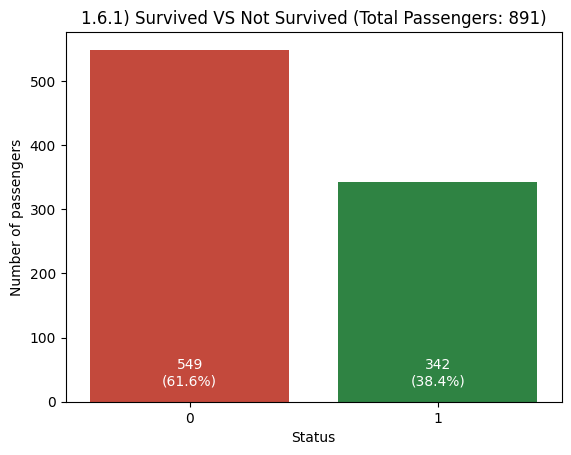

In [ ]:
title = f'1.6.1) Survived VS Not Survived (Total Passengers: {len(dfp)})'
makeBarchart2(dfp,'Survived', None, ['#d93725', '#21913c'], title, True, None, 'Status')

The plot above showcase *Not Survived passengers* as 0 and *Survived passengers* as 1. Only 38.4% of the passengers aboard the Titanic survived.

#### 1.6.2) Survived VS Not Survived Split by Gender

In [ ]:
#makeBarchart2(dfp,'Sex',None,['blue','pink'],'Distribution of Passengers by Sex', None, None, 'Sex')

In [ ]:
#makeBarchart2(dfp[dfp['Survived'] == 1],'Sex',None,['pink','blue'],'Survived Passengers by Sex', None, None, 'Sex')

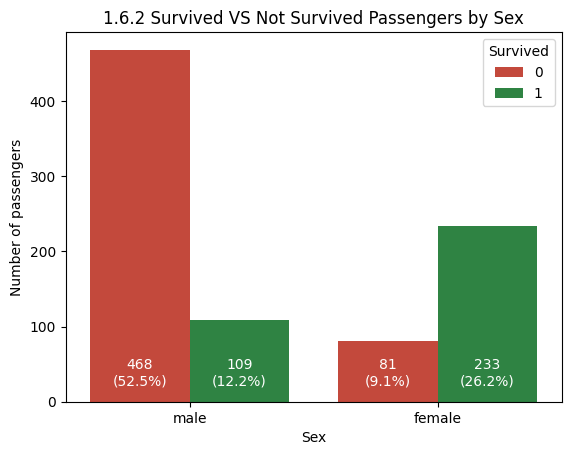

In [ ]:
makeBarchart2(dfp,'Sex','Survived', ['#d93725', '#21913c'],'1.6.2 Survived VS Not Survived Passengers by Sex', 'Survived', 'centre', 'Sex')

In green are the surviving passengers, while in red are the casualties.

The number of male passengers is almost double the number of female passengers (577 vs 314). Despite this, we can clearly see that the number of surviving female passengers is more than twice the number of male passengers. The survival rate of women far exceeds that of male passengers.

#### 1.6.3) Passangers Class

In [ ]:
#makeBarchart2(dfp,'Pclass',None,'mako','1.6.3 Total Number of Passengers by Class', None, None, 'Class')

In [ ]:
#makeBarchart2(dfp[dfp['Survived'] == 1],'Pclass',None,'mako','Survived by Class', None, None, 'Class')

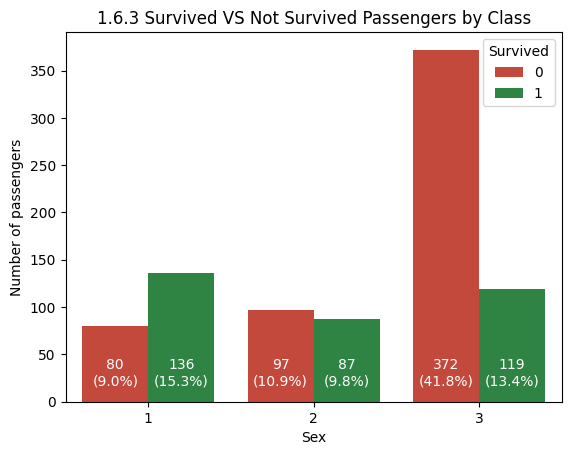

In [ ]:
makeBarchart2(dfp,'Pclass','Survived', ['#d93725', '#21913c'],'1.6.3 Survived VS Not Survived Passengers by Class', 'Survived', 'centre', 'Sex')

Over half of passengers were in third class (55%).

First-class passengers had a 62% survival rate, while second-class passengers had slightly lower odds, with about a 50/50 chance of survival. Conversely, for third-class passengers, survival was very unlikely.

The unfortunate fate that third-class passengers met is somewhat expected, as lower-class passengers likely had cabins situated below deck and possibly in very cramped areas. Consequently, they would have been the first ones to face danger and possibly had a harder time reaching the upper decks due to overcrowding of the spaces.

#### 1.6.4) Passangers Age

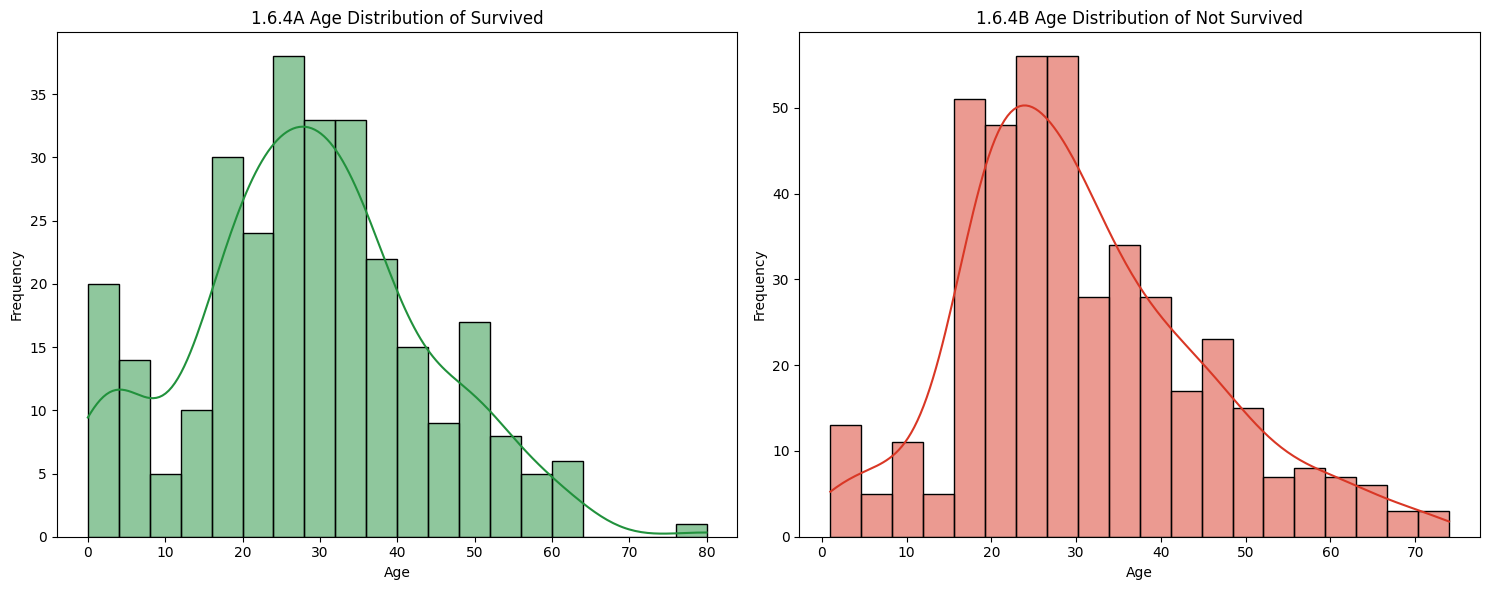

In [ ]:
survived_passengers = dfp[dfp['Survived'] == 1]
not_survived_passengers = dfp[dfp['Survived'] == 0]

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Survived plot
sns.histplot(survived_passengers['Age'], bins=20, color='#21913c', kde=True, ax=axs[0])
axs[0].set_title('1.6.4A Age Distribution of Survived')
axs[0].set_xlabel('Age')
axs[0].set_ylabel('Frequency')

# Not Survived plot
sns.histplot(not_survived_passengers['Age'], bins=20, color='#d93725', kde=True, ax=axs[1])
axs[1].set_title('1.6.4B Age Distribution of Not Survived')
axs[1].set_xlabel('Age')
axs[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


The graph on the left shows that the majority of survivors were under 30 years old. There is a peak in frequency around age 20-25. The frequency gradually decreases as age increases.

The graph on the right shows that the majority of those who did not survive were over 30 years old. There is a peak in frequency around age 40-45. Similar to the survival graph, the frequency gradually decreases as age decreases.

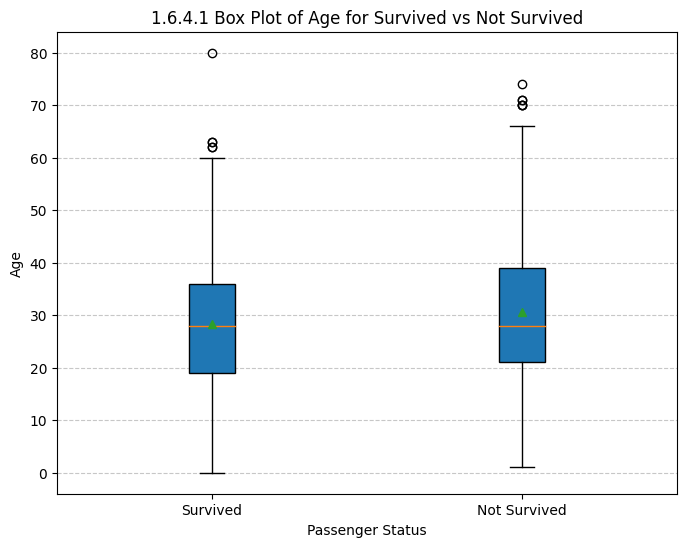

In [ ]:
# Filter data for survivors and casualties
survivors_age = df.filter(col("Survived") == "1").select("Age").collect()
casualties_age = df.filter(col("Survived") == "0").select("Age").collect()

# Extract ages from Row objects and convert to float
survivors_age = [float(row.Age) for row in survivors_age if row.Age is not None]
casualties_age = [float(row.Age) for row in casualties_age if row.Age is not None]

# Prepare data for box plots
data = [survivors_age, casualties_age]
labels = ['Survived', 'Not Survived']

# Create box plots
plt.figure(figsize=(8, 6))
plt.boxplot(data, labels=labels, patch_artist=True, showmeans=True)
plt.xlabel('Passenger Status')
plt.ylabel('Age')
plt.title('1.6.4.1 Box Plot of Age for Survived vs Not Survived')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Among the passengerd that didn't survive, there are more outliers, and the boxplot is longer. The age of the casualties tends to be between 1 and 66, while survivors are between 0 and 60.

#### 1.6.5) Port of embarkation

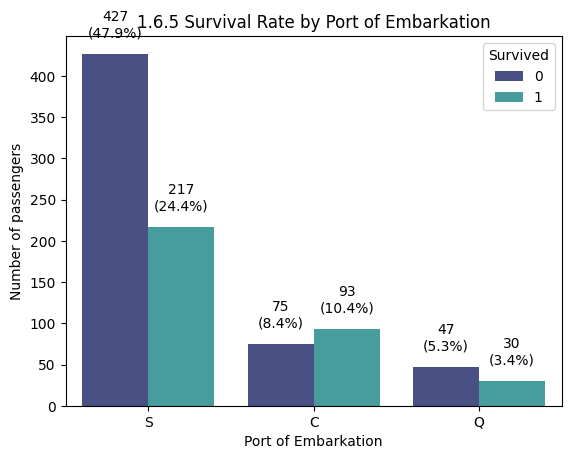

In [ ]:
#makeBarchart2(dfp[dfp['Survived'] == 1],'Embarked',None,'mako','',None,'top','Port of Embarkation')
makeBarchart2(dfp,'Embarked','Survived','mako','1.6.5 Survival Rate by Port of Embarkation',None,'top','Port of Embarkation')

Passengers who embarked from Southampton had the highest number of survivors, followed by Cherbourg, and then Queenstown. However, it's important to consider the total number of people who boarded the Titanic in those ports. This suggests that while more passengers survived from Southampton overall, the proportion of survivors compared to the total number who embarked from that port show that Cherbourg passengers had a higher survival rate.

#### 1.6.6) Number of siblings/spouses aboard (SibSp)

<ipython-input-16-8fffab59b8e8>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=target, hue=hue, data=df, palette=color_palette) if hue else sns.countplot(x=target, data=df, palette=color_palette)


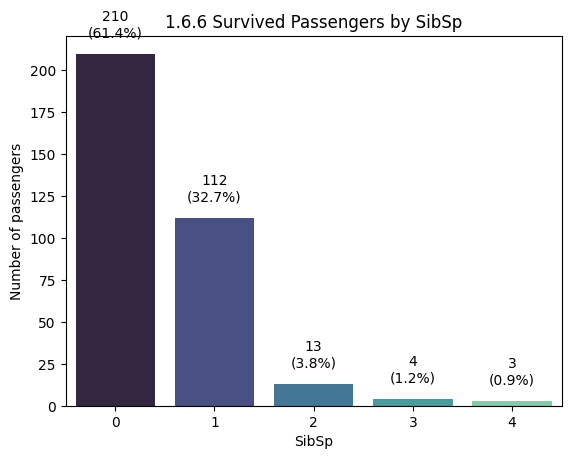

In [ ]:
#makeBarchart2(dfp,'SibSp',None,'mako','Passangers by SibSp',None,'top','SibSp') #all
makeBarchart2(dfp[dfp['Survived'] == 1],'SibSp',None,'mako','1.6.6 Survived Passengers by SibSp',None,'top','SibSp') #survived

It is evident that passengers with fewer siblings/spouses (SibSp) had a higher survival rate compared to those with more siblings/spouses. This observation suggests that having a smaller family size might have increased the chances of survival.

#### 1.6.7) Number of parents/children aboard

<ipython-input-16-8fffab59b8e8>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=target, hue=hue, data=df, palette=color_palette) if hue else sns.countplot(x=target, data=df, palette=color_palette)


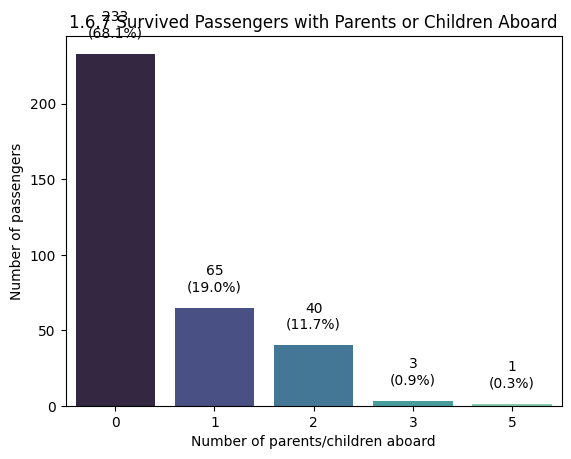

In [ ]:
makeBarchart2(dfp[dfp['Survived'] == 1],'Parch',None,'mako','1.6.7 Survived Passengers with Parents or Children Aboard',None,'top','Number of parents/children aboard')

The survival trend observed in plot 1.6.6 is also reflected in the 1.6.7 Parch plot, where passengers not having children or parents dependent on them ahd a better chance at surviving.

#### 1.6.8) Ticket Fare

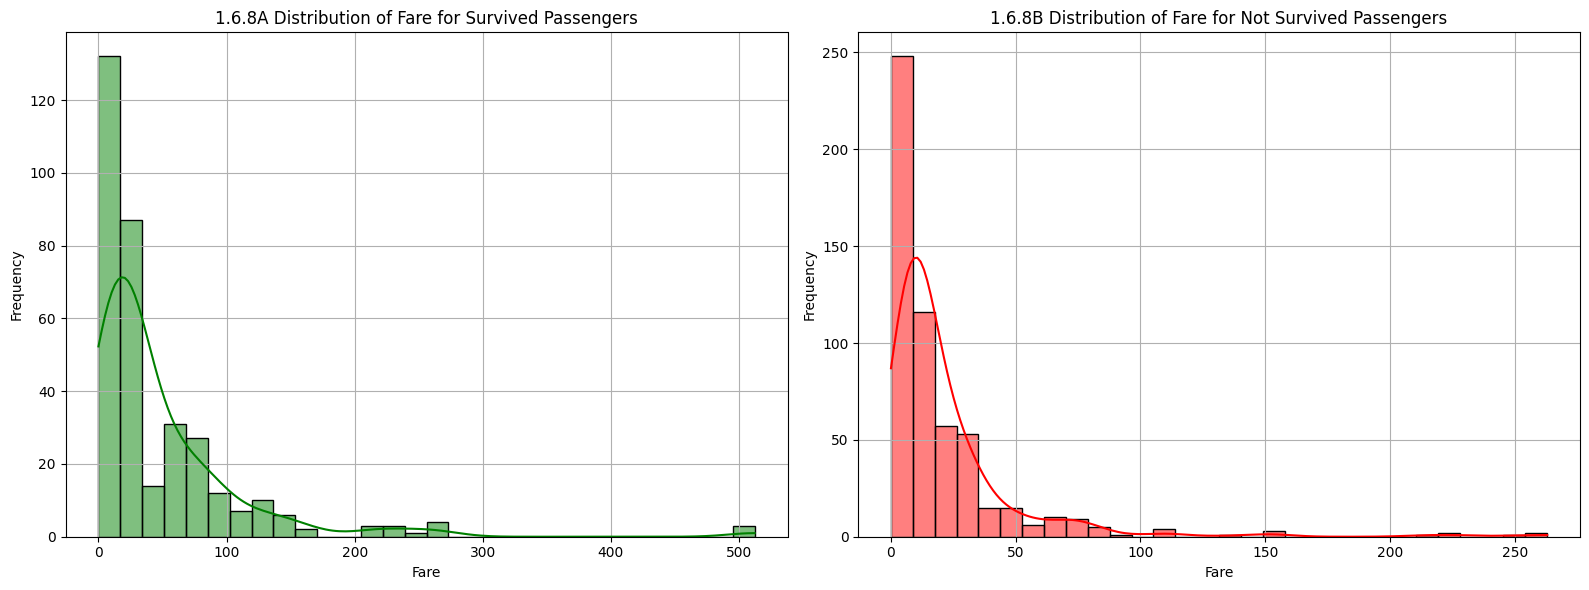

In [ ]:
# Filter the DataFrame for survived and not survived passengers separately
survived_fare = dfp[dfp['Survived'] == 1]['Fare']
not_survived_fare = dfp[dfp['Survived'] == 0]['Fare']

# Setting up the figure and axes for the subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plotting the distribution of fares for survivors
sns.histplot(survived_fare, kde=True, color='green', bins=30, ax=axes[0])
axes[0].set_title('1.6.8A Distribution of Fare for Survived Passengers')
axes[0].set_xlabel('Fare')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

# Plotting the distribution of fares for non-survivors
sns.histplot(not_survived_fare, kde=True, color='red', bins=30, ax=axes[1])
axes[1].set_title('1.6.8B Distribution of Fare for Not Survived Passengers')
axes[1].set_xlabel('Fare')
axes[1].set_ylabel('Frequency')
axes[1].grid(True)

# Displaying the plots
plt.tight_layout()
plt.show()


Distribution of fares for passengers by whether they survived or not.

The distribution for survived passengers (left graph) has a peak around 100 fare units, and trails off to zero around 300 fare units.

The distribution for not-survived passengers (right graph) has a peak closer to 150 fare units, and also trails off to zero around 300 fare units.

However, it is interesting to note that the distribution of fares for the two groups is very similar (both right-skewed). This suggests that the fare variable alone may not be the major factor in whether or not a passenger survived.

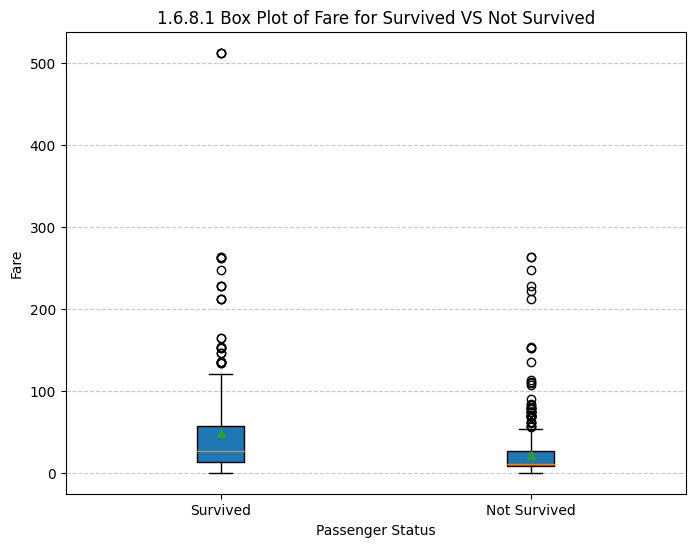

In [ ]:
# Filter data for survivors and casualties
survivors_fare = df.filter(col("Survived") == "1").select("Fare").collect()
casualties_fare = df.filter(col("Survived") == "0").select("Fare").collect()

# Extract fares from Row objects
survivors_fare = [row.Fare for row in survivors_fare if row.Fare is not None]
casualties_fare = [row.Fare for row in casualties_fare if row.Fare is not None]

# Prepare data for box plots
data = [survivors_fare, casualties_fare]
labels = ['Survived', 'Not Survived']

# Create box plots
plt.figure(figsize=(8, 6))
plt.boxplot(data, labels=labels, patch_artist=True, showmeans=True)
plt.xlabel('Passenger Status')
plt.ylabel('Fare')
plt.title('1.6.8.1 Box Plot of Fare for Survived VS Not Survived')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


* The fare for most passengers who survived cost between 0 and 125. The whiskers for the survived group extend up to 500, highlighting some large outliers.
* The fare for most passengers who did not survive was between 0 and 50.
* The median fare price was higher for passengers who survived than for those who did not survive.

Overall, the boxplot suggests that there may have been a relationship between a passenger's ticket fare and their survival on the Titanic.

## 2) Data Cleaning

### 2.1) Managing "Age" missing values
Strategy to handle missing values:

1. Extract the titles from the "Name" column.
2. Replace less common titles with more common ones.
3. Group by gender, class, and title, and calculate the average age for each group.
4. Fill missing age values with the corresponding median age (dropping the temporary column used for calculating the average age).

In [7]:
# 1) get the title from 'Name' column
df = df.withColumn("Title", regexp_extract("Name", "([A-Za-z]+)\.", 1))

In [8]:
(df.groupBy("Title").count()).orderBy('count').show()

+--------+-----+
|   Title|count|
+--------+-----+
|     Don|    1|
|Countess|    1|
|    Lady|    1|
|     Mme|    1|
|    Capt|    1|
|     Sir|    1|
|Jonkheer|    1|
|      Ms|    1|
|     Col|    2|
|    Mlle|    2|
|   Major|    2|
|     Rev|    6|
|      Dr|    7|
|  Master|   40|
|     Mrs|  125|
|    Miss|  182|
|      Mr|  517|
+--------+-----+



In [9]:
from pyspark.sql.functions import regexp_replace

# Define a regular expression pattern to match the titles to be replaced
titles_to_replace = ["Capt", "Col", "Major", "Dr", "Rev"]
pattern = "|".join(titles_to_replace)

# Replace titles in the "Title" column with "Officer"
df = df.withColumn("Title", regexp_replace(col("Title"), pattern, "Officer"))

# Show the updated DataFrame
df.select("Title").distinct().show(truncate=False)

+--------+
|Title   |
+--------+
|Don     |
|Miss    |
|Countess|
|Officer |
|Lady    |
|Master  |
|Mme     |
|Mr      |
|Mrs     |
|Sir     |
|Jonkheer|
|Mlle    |
|Ms      |
+--------+



In [10]:
from pyspark.sql.functions import regexp_replace

# Define a regular expression pattern to match the additional titles to be replaced
additional_titles_to_replace = ["Jonkheer", "Don", "Sir", "Countess", "Dona", "Lady"]
additional_pattern = "|".join(additional_titles_to_replace)

# Replace additional titles in the "Title" column with "Noble"
df = df.withColumn("Title", regexp_replace(col("Title"), additional_pattern, "Noble"))

# Show the updated DataFrame
df.select("Title").distinct().show(truncate=False)

+-------+
|Title  |
+-------+
|Miss   |
|Officer|
|Master |
|Mme    |
|Noble  |
|Mr     |
|Mrs    |
|Mlle   |
|Ms     |
+-------+



In [11]:
from pyspark.sql.functions import regexp_replace

# Define a dictionary to map titles to their replacements
title_replacements = {
    "Mme": "Mrs",
    "Ms": "Mrs",
    "Mlle": "Miss"
}

# Iterate over the dictionary and replace titles in the "Title" column
for old_title, new_title in title_replacements.items():
    df = df.withColumn("Title", regexp_replace(col("Title"), old_title, new_title))

# Show the updated DataFrame
df.select("Title").distinct().show(truncate=False)

+-------+
|Title  |
+-------+
|Miss   |
|Officer|
|Master |
|Noble  |
|Mr     |
|Mrs    |
+-------+



In [12]:
# 3) group by Sex, Class, and Title, and calculate the avg age for each group
avg_age_by_group = df\
    .groupBy("Sex", "Pclass", "Title") \
    .agg(F.mean("Age").cast('int').alias("AvgAge"))

avg_age_by_group.show()

+------+------+-------+------+
|   Sex|Pclass|  Title|AvgAge|
+------+------+-------+------+
|  male|     1| Master|     5|
|  male|     1|     Mr|    41|
|  male|     2|Officer|    42|
|  male|     2|     Mr|    32|
|  male|     1|Officer|    51|
|female|     3|    Mrs|    33|
|female|     1|   Miss|    29|
|female|     1|Officer|    49|
|female|     2|   Miss|    22|
|  male|     1|  Noble|    42|
|  male|     3| Master|     5|
|female|     3|   Miss|    16|
|  male|     3|     Mr|    28|
|  male|     2| Master|     2|
|female|     1|    Mrs|    40|
|female|     1|  Noble|    40|
|female|     2|    Mrs|    33|
+------+------+-------+------+



In [13]:
# 4) fill missing values with corresponding AvgAge
df_with_avg = df.join(avg_age_by_group, ["Sex", "Pclass", "Title"], "left")

#Replace missing values in the 'Age' column with the AvgAge where missing
df = df_with_avg.withColumn("Age", when(col("Age").isNull(), col("AvgAge")).otherwise(col("Age")))

df = df.withColumn("Age", col("Age").cast(IntegerType()))

df = df.drop("AvgAge")

#df.select("Age").show()

In [14]:
df.filter(col('Age').isNull()).count()

0

### 2.2) Managing "Embarked" missing values

With only two missing values, dropping the rows is an acceptable solution.

In [15]:
df = df.filter(col("Embarked").isNotNull())

In [16]:
(df.filter(col("Embarked").isNull())).count()

0

### 2.3) Managing "Cabin" missing values

To manage the missing values in the 'Cabin' column, the values were converted into a binary indicator:
- 0 represents passengers without a cabin.
- 1 represents passengers with a cabin.

In [17]:
df = df.withColumn('Cabin', when(col('Cabin').isNull(), 0).otherwise(1))
#df.select("Cabin").show()

In [18]:
(df.filter(col("Cabin").isNull())).count()

0

### 2.4) Fare modeling

To address the outliers in the 'Fare' column, it was decided to replace values above 500 with the next highest values. This approach ensures that extremely high fares, indicating wealthy passengers likely traveling in first class, are still retained in the dataset.

In [19]:
# Replace values above 200 in the "Fare" column with 150
df = df.withColumn("Fare", when(col("Fare") > 200, 150).otherwise(col("Fare")))

#df.select("Fare").show()

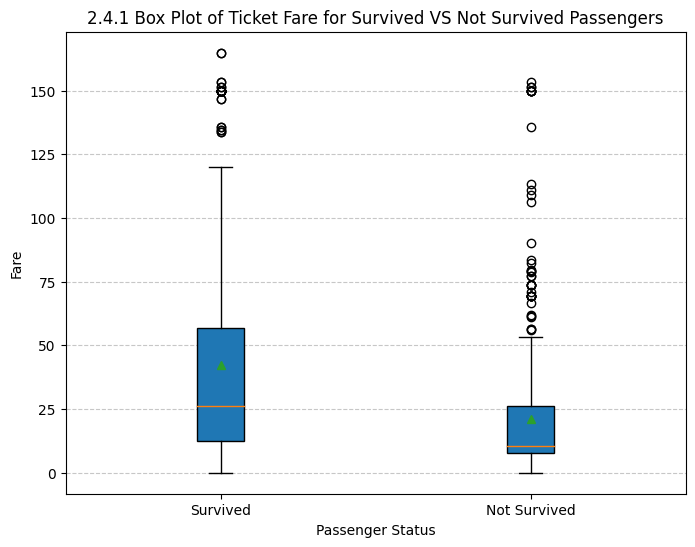

In [20]:
# Filter data for survivors and casualties
survivors_fare = df.filter(col("Survived") == "1").select("Fare").collect()
casualties_fare = df.filter(col("Survived") == "0").select("Fare").collect()

# Extract fares from Row objects
survivors_fare = [row.Fare for row in survivors_fare if row.Fare is not None]
casualties_fare = [row.Fare for row in casualties_fare if row.Fare is not None]

# Prepare data for box plots
data = [survivors_fare, casualties_fare]
labels = ['Survived', 'Not Survived']

# Create box plots
plt.figure(figsize=(8, 6))
plt.boxplot(data, labels=labels, patch_artist=True, showmeans=True)
plt.xlabel('Passenger Status')
plt.ylabel('Fare')
plt.title('2.4.1 Box Plot of Ticket Fare for Survived VS Not Survived Passengers')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

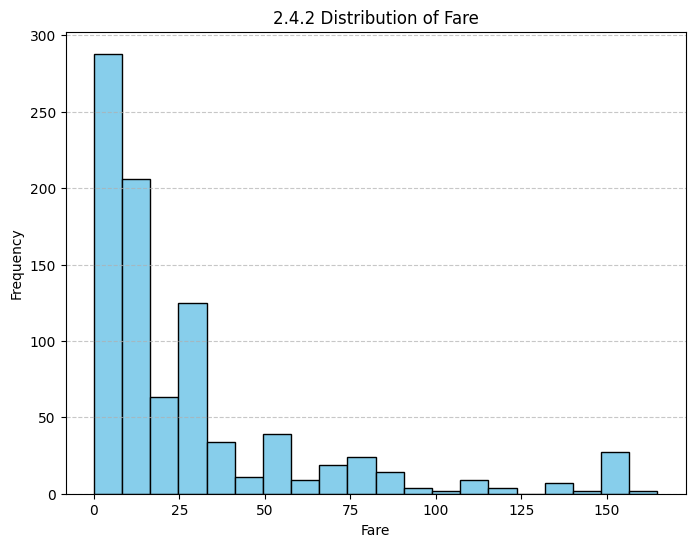

In [21]:
# Extract fares from the DataFrame
fares = df.select("Fare").rdd.flatMap(lambda x: x).collect()

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(fares, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Fare')
plt.ylabel('Frequency')
plt.title('2.4.2 Distribution of Fare')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [22]:
from pyspark.sql.functions import format_number

# Clean the "Fare" column to have two decimal places
df = df.withColumn("Fare", format_number(col("Fare"), 2))

# Show the cleaned "Fare" column
df.select("Fare").show()

+-----+
| Fare|
+-----+
| 7.25|
|71.28|
| 7.92|
|53.10|
| 8.05|
| 8.46|
|51.86|
|21.07|
|11.13|
|30.07|
|16.70|
|26.55|
| 8.05|
|31.27|
| 7.85|
|16.00|
|29.12|
|13.00|
|18.00|
| 7.22|
+-----+
only showing top 20 rows



In [23]:
from pyspark.sql.functions import col

# Convert "Fare" column from string to float
df = df.withColumn("Fare", col("Fare").cast("float"))

## 3) Modeling

### 3.1) Feature engineering

#### 3.1.1) AgeCategory

Group 'Age' into categories and convert to integer value:

| Value Range | Integer   |
|:------------|:---------:|
| x ≤ 17      | 0         |
| 17 < x ≤ 32 | 1         |
| 32 < x ≤ 48 | 2         |
| 48 < x ≤ 64 | 3         |
| x > 64      | 4         |

In [24]:
df = df.withColumn("AgeCategory",
    F.when(df['Age'] <= 17, 0)
    .when((df['Age'] > 17) & (df['Age'] <= 32), 1)
    .when((df['Age'] > 32) & (df['Age'] <= 48), 2)
    .when((df['Age'] > 48) & (df['Age'] <= 64), 3)
    .otherwise(4)
)

#### 3.1.2) Sex
Convert categorical features into numerical
- Sex:
  - male = 1,
  - female = 2

In [25]:
df = df.withColumn("Sex", when(df["Sex"] == "male", 1).otherwise(2))

#### 3.1.3) Embarked
Convert categorical features into numerical
- Embarked:
  - C = 1,
  - Q = 2,
  - S = 3

In [26]:
df = df.withColumn("Embarked", when(df["Embarked"] == "C", 1).when(df["Embarked"] == "Q", 2).otherwise(3))

#### 3.1.4) Final dataset

In [27]:
df=df.drop('PassengerId','Name','Ticket','Title','Age')

In [28]:
df.cache()

DataFrame[Sex: int, Pclass: int, Survived: int, SibSp: int, Parch: int, Fare: float, Cabin: int, Embarked: int, AgeCategory: int]

Let's see how it looks!

In [29]:
df.printSchema()

root
 |-- Sex: integer (nullable = false)
 |-- Pclass: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Fare: float (nullable = true)
 |-- Cabin: integer (nullable = false)
 |-- Embarked: integer (nullable = false)
 |-- AgeCategory: integer (nullable = false)



In [30]:
df.show(20)

+---+------+--------+-----+-----+-----+-----+--------+-----------+
|Sex|Pclass|Survived|SibSp|Parch| Fare|Cabin|Embarked|AgeCategory|
+---+------+--------+-----+-----+-----+-----+--------+-----------+
|  1|     3|       0|    1|    0| 7.25|    0|       3|          1|
|  2|     1|       1|    1|    0|71.28|    1|       1|          2|
|  2|     3|       1|    0|    0| 7.92|    0|       3|          1|
|  2|     1|       1|    1|    0| 53.1|    1|       3|          2|
|  1|     3|       0|    0|    0| 8.05|    0|       3|          2|
|  1|     3|       0|    0|    0| 8.46|    0|       2|          1|
|  1|     1|       0|    0|    0|51.86|    1|       3|          3|
|  1|     3|       0|    3|    1|21.07|    0|       3|          0|
|  2|     3|       1|    0|    2|11.13|    0|       3|          1|
|  2|     2|       1|    1|    0|30.07|    0|       1|          0|
|  2|     3|       1|    1|    1| 16.7|    1|       3|          0|
|  2|     1|       1|    0|    0|26.55|    1|       3|        

### 3.2) Models
Transforming the features into a vector format using PySpark's VectorAssembler

In [31]:
# PySPark Libraries
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [32]:
assembler = VectorAssembler(
  inputCols = ['Pclass', 'Sex','SibSp','Fare', 'Parch' ,'Embarked', 'Cabin','AgeCategory'],
  outputCol="features"
)

In [33]:
test_size = 0.2
test_seed = 2024
train_data, test_data = df.randomSplit([1-test_size,test_size],seed=test_seed)

In [ ]:
'''
train_data.printSchema()
train_data.show()
train_data.describe().show()
'''

'\ntrain_data.printSchema()\ntrain_data.show()\ntrain_data.describe().show()\n'

In [34]:
pipeline1 = Pipeline(stages=[assembler])

In [35]:
evaluator = BinaryClassificationEvaluator(labelCol="Survived")

def getCrossValidator(estimator, params, folds):
  return CrossValidator(
      estimator=estimator,
      estimatorParamMaps=params,
      evaluator=evaluator,
      numFolds=folds,
      seed=101
  )

#### 3.3.1) Logistic Regression

In [36]:
lr = LogisticRegression(
    featuresCol="features",
    labelCol="Survived"
)

lr_hp_grid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.1, 0.01])\
    .addGrid(lr.elasticNetParam, [0.01 ,0.1, 0.5])\
    .build()

pipeline_lr = Pipeline(stages=[pipeline1, getCrossValidator(lr, lr_hp_grid, 3)])

model_lr = pipeline_lr.fit(train_data)

# best model
best_lr_model = model_lr.stages[-1].bestModel
print("Best regularization parameter (regParam):", best_lr_model._java_obj.getRegParam())
print("Best elastic net parameter (elasticNetParam):", best_lr_model._java_obj.getElasticNetParam())

Best regularization parameter (regParam): 0.1
Best elastic net parameter (elasticNetParam): 0.01


In [37]:
# lr with best parameters
best_lr_model = LogisticRegression(
    featuresCol="features",
    labelCol="Survived",
    regParam=best_lr_model._java_obj.getRegParam(),
    elasticNetParam=best_lr_model._java_obj.getElasticNetParam()
)

pipeline_best_lr = Pipeline(stages=[pipeline1, best_lr_model])

model1 = pipeline_best_lr.fit(train_data)

#### 3.3.2) Linear SVC

In [40]:
lsvc = LinearSVC(
    featuresCol="features",
    labelCol="Survived"
)

lsvc_hp_grid = ParamGridBuilder()\
    .addGrid(lsvc.maxIter, [5, 25, 50])\
    .addGrid(lsvc.regParam, [0.1, 0.3, 1.6])\
    .addGrid(lsvc.fitIntercept, [True, False])\
    .build()

pipeline_lsvc = Pipeline(stages=[pipeline1, getCrossValidator(lsvc, lsvc_hp_grid, 3)])

model_lsvc = pipeline_lsvc.fit(train_data)

# best model
best_lsvc_model = model_lsvc.stages[-1].bestModel
print("Best max iteration:", best_lsvc_model.getMaxIter())
print("Best regularization parameter:", best_lsvc_model.getRegParam())

Best max iteration: 5
Best regularization parameter: 0.3


In [41]:
# lsvc with best parameters
best_pipeline_lsvc = Pipeline(stages=[pipeline1, best_lsvc_model])
model2 = best_pipeline_lsvc.fit(train_data)

#### 3.3.3) Decision Tree Classifier

In [42]:
dt = DecisionTreeClassifier(labelCol="Survived")

dt_hp_grid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10, 15]) \
    .addGrid(dt.maxBins, [32, 64]) \
    .addGrid(dt.minInstancesPerNode, [1, 5, 10]) \
    .addGrid(dt.impurity, ['gini', 'entropy']) \
    .build()

pipeline_dt = Pipeline(stages=[pipeline1, getCrossValidator(dt, dt_hp_grid, 3)])

model_dt = pipeline_dt.fit(train_data)

# best model
best_dt_model = model_dt.stages[-1].bestModel
print("Best max depth:", best_dt_model.getMaxDepth())
print("Best max bins:", best_dt_model.getMaxBins())
print("Best min instances per node:", best_dt_model.getMinInstancesPerNode())
print("Best impurity:", best_dt_model.getImpurity())

Best max depth: 15
Best max bins: 64
Best min instances per node: 1
Best impurity: gini


In [43]:
best_pipeline_dt = Pipeline(stages=[pipeline1, best_dt_model])
model3 = best_pipeline_dt.fit(train_data)

#### 3.3.4) Random Forest

In [44]:
rf = RandomForestClassifier(
    labelCol="Survived"
)

rf_hp_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50]) \
    .addGrid(rf.maxDepth, [30]) \
    .addGrid(rf.minInstancesPerNode, [1, 5]) \
    .addGrid(rf.maxBins, [64]) \
    .addGrid(rf.minInfoGain, [0.0, 0.1]) \
    .build()

pipeline_rf = Pipeline(stages=[pipeline1, getCrossValidator(rf, rf_hp_grid, 5)])

model_rf = pipeline_rf.fit(train_data)

# best model
best_rf_model = model_rf.stages[-1].bestModel
print("Best number of trees:", best_rf_model.getNumTrees)
print("Best max depth:", best_rf_model.getMaxDepth())

Best number of trees: 50
Best max depth: 30


In [45]:
best_pipeline_rf = Pipeline(stages=[pipeline1, best_rf_model])
model4 = best_pipeline_rf.fit(train_data)

#### 3.3.5) Multilayer Perceptron Classifier

In [48]:
mlp = MultilayerPerceptronClassifier(
  labelCol="Survived"
)

test_layer1 = [[8, 5, 2], [8, 5, 5, 2]]
test_layer2 = [[8, 5, 5, 2], [8, 5, 5, 5, 2]]
test_layer3 = [[8, 5, 5, 5, 2],[8, 6, 5, 4, 3, 2]]

test_stepSize1 = [0.001, 0.03]
test_stepSize2 = [0.02, 0.04]
test_stepSize3 = [0.02, 0.025, 0.03, 0.035, 0.04]

mlp_hp_grid = ParamGridBuilder() \
    .addGrid(mlp.layers, test_layer2) \
    .addGrid(mlp.stepSize, test_stepSize2) \
    .addGrid(mlp.maxIter, [100, 150, 200]) \
    .addGrid(mlp.blockSize, [64, 128]) \
    .addGrid(mlp.tol, [1e-4, 1e-6]) \
    .build()

pipeline_mlp = Pipeline(stages=[pipeline1, getCrossValidator(mlp, mlp_hp_grid, 3)])

model_mlp = pipeline_mlp.fit(train_data)

# best model
best_perc_model = model_mlp.stages[-1].bestModel

print("Best layers:", best_perc_model.getLayers())
print("Best max iteration:", best_perc_model.getMaxIter())
print("Best step size:", best_perc_model.getStepSize())
print("Best blockSize:", best_perc_model.getBlockSize())
print("Best tol:", best_perc_model.getTol())

Best layers: [8, 5, 5, 5, 2]
Best max iteration: 150
Best step size: 0.02
Best blockSize: 128
Best tol: 0.0001


In [49]:
best_pipeline_perc = Pipeline(stages=[pipeline1, best_perc_model])
model5 = best_pipeline_perc.fit(train_data)

### 3.4) Models comparison

In [50]:
evaluator = BinaryClassificationEvaluator(labelCol="Survived")

models = [model1, model2, model3, model4, model5]
model_names = ["LR", "LSVC", "DTC", "RF", "MLP"]

for i in range(len(models)):
    predictionsTrain = models[i].transform(train_data)
    auc_train = evaluator.evaluate(predictionsTrain)
    print(model_names[i])
    print("AUC (train set): ", auc_train)

    predictionsTest = models[i].transform(test_data)
    auc_test = evaluator.evaluate(predictionsTest)
    print("AUC (test set): ", auc_test)

    accuracy = MulticlassClassificationEvaluator(labelCol='Survived', metricName='accuracy').evaluate(predictionsTest)
    precision = MulticlassClassificationEvaluator(labelCol='Survived', metricName='weightedPrecision').evaluate(predictionsTest)
    print('Accuracy: ', accuracy)
    print('Precision: ', precision)
    print('-----')

LR
AUC (train set):  0.8583866441731108
AUC (test set):  0.8582927489177488
Accuracy:  0.8258426966292135
Precision:  0.8244424786546178
-----
LSVC
AUC (train set):  0.8591716915265002
AUC (test set):  0.8532873376623373
Accuracy:  0.8033707865168539
Precision:  0.80126512729202
-----
DTC
AUC (train set):  0.8016293908366601
AUC (test set):  0.7456709956709957
Accuracy:  0.797752808988764
Precision:  0.7991558012377575
-----
RF
AUC (train set):  0.9587516076767609
AUC (test set):  0.8520698051948054
Accuracy:  0.797752808988764
Precision:  0.7966409176029963
-----
MLP
AUC (train set):  0.8513295695602074
AUC (test set):  0.864786255411255
Accuracy:  0.8033707865168539
Precision:  0.8010322025697543
-----


| Model | AUC (train set) | AUC (test set) | Accuracy | Precision |
|-------|-----------------|----------------|----------|-----------|
| LR    | 0.858           | 0.858          | 0.826    | 0.824     |
| LSVC  | 0.859           | 0.853          | 0.803    | 0.801     |
| RF    | 0.922           | 0.860          | 0.803    | 0.801     |
| MLP   | 0.870           | 0.839          | 0.798    | 0.797     |
| DTCRF | 0.802           | 0.746          | 0.798    | 0.799     |

The Random Forest (RF) model seems to perform the best among the models listed:

- **AUC**: The model has the highest AUC score on both the train set (0.921) and the test set (0.860). Meaning it can effectively distinguish between the positive and negative classes.
- **Precision**: The precision of the RF model is also higher compared to LR, LSVC, and MLP.
- **Consistency**: The RF model shows good consistency between the AUC scores on the train and test sets, indicating that it is less likely to be overfitting the training data.

The Logistic Regression slightly outperforms the Random Forest model in terms of accuracy and precision, however overall the Random Forest is more competitive on the area under the curve metrics.

### 3.5) Evaluation

In [51]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [52]:
predictions = model4.transform(test_data) #JM FIX is the random forest still the best model?
class_temp = predictions\
    .select("Survived")\
    .groupBy("Survived")\
    .count()\
    .sort('count', ascending=False)\
    .toPandas()

class_temp = class_temp["Survived"].values.tolist()

In [53]:
predictions.printSchema()

root
 |-- Sex: integer (nullable = false)
 |-- Pclass: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Fare: float (nullable = true)
 |-- Cabin: integer (nullable = false)
 |-- Embarked: integer (nullable = false)
 |-- AgeCategory: integer (nullable = false)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



Evaluation for predictions

In [54]:
from sklearn.metrics import confusion_matrix
y_true = predictions.select("Survived")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix

array([[95, 17],
       [19, 47]])

Confusion matrix, without normalization
[[95 17]
 [19 47]]


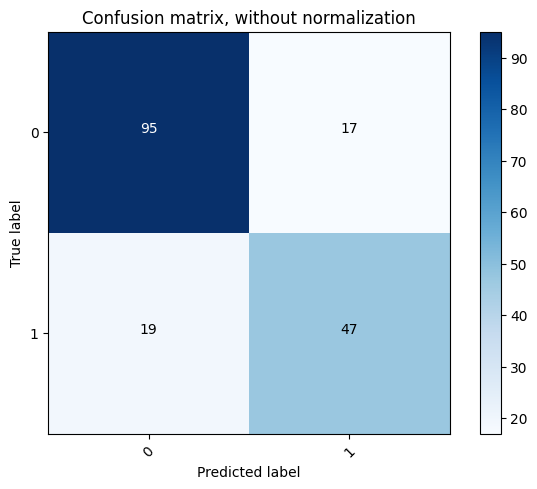

In [55]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(
    cnf_matrix,
    classes=["0", "1"],
    title='Confusion matrix, without normalization'
)

plt.show()

Confusion matrix, without normalization

|Label|Predicted 0|Predicted 1|
|:--:|:--:|:--:|
|**True 0**|95|17|
|**True 1**|19|47|

The model demonstrates a relatively good performance with high recall for both classes, indicating that it captures a large portion of actual survivors and non-survivors. However, precision for class 1 (survived) is lower compared to class 0 (not survived), suggesting that the model has more false positive predictions for survivors. This might be an area for further improvement.

Normalized confusion matrix
[[0.84821429 0.15178571]
 [0.28787879 0.71212121]]


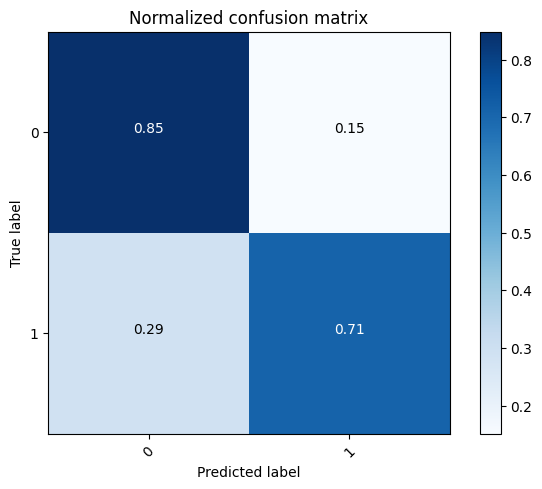

In [56]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(
    cnf_matrix,
    classes=["0", "1"],
    normalize=True,
    title='Normalized confusion matrix'
)

plt.show()

Confusion matrix, with normalization

|Label|Predicted 0|Predicted 1|
|:--:|:--:|:--:|
|**True 0**|0.85|0.15|
|**True 1**|0.29|0.71|

The model performed well but not perfectly. For instance, the model  incorrectly classified 29% of those who died and 15% of those who survived. Overall, the model seems to be classifying more passengers correctly than incorrectly, but it is still making some mistakes.

## 4) Conclusion

Based on the analysis conducted, emerging patterns in the data reveal a clear relationship between survival outcomes and gender, age, and wealth. It is evident that women and children were more likely to survive, and social status (title) or cabin class also influenced survival probabilities. Lastly, it can be obselrved that unattached passengers also were more likely to survive, possibly because they did not have any loved one depending on them to survive (spouse, parents, children or siblings).Further exploration into the social and economic dynamics of society in the early 1910s, along with a deeper understanding of the Titanic ship, would help to better inform these patterns.

Among the explored models, the Random Forest (RF) model performs the best in predicting survival outcomes for passengers aboard the Titanic. The RF model demonstrates superior discriminatory power, as evidenced by its higher Area Under the Curve (AUC) score on test set. Overall, the RF model's competitive performance across all metrics suggests its suitability for this classification task.

However, it's essential to acknowledge the limitations of this study. The analysis was conducted on a specific dataset with inherent biases and missing information, which may have influenced model performance. Additionally, while the evaluation metrics used provide a comprehensive assessment, they may not capture all aspects of model performance.

Further exploration of other variables not fully explored in this dataset could help improve the model accuracy in predicting the survival or death of a passenger. Specifically, the metrics highlight that the model is relatively good at predicting the death or survival of a passenger but still has room for improvement, as it has some false positives.